<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-Daily-from-Scratch/blob/main/Wine_Reviews_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [31]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [32]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [33]:
df =df.dropna(subset=['description', 'points'])

In [34]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


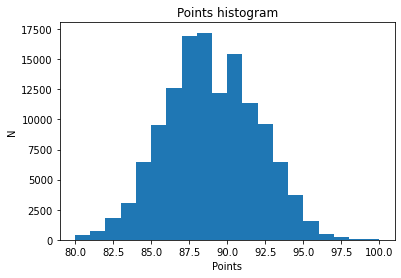

In [35]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [36]:
df["label"] = (df.points >= 90).astype(int)
df = df[['description', 'points','label']]

In [39]:
df.head()

,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


### Splitting training data and validation data

In [40]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [41]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [43]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label') # target
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [44]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding + Model
### nnlm-en-dim50
Token based text embedding trained on English Google News 7B corpus.

In [45]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [48]:
# Transformed text into vector of numbers for the model to understand
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.41691396, -0.21040307, -0.11966962, ...,  0.10890358,
         0.15431839, -0.08482464],
       [ 0.24052373, -0.10584494,  0.07657898, ..., -0.0721566 ,
        -0.21858299,  0.08648967],
       [ 0.4151127 , -0.36791524, -0.08613624, ..., -0.0628197 ,
        -0.03065088, -0.11706799],
       ...,
       [ 0.46040702, -0.2839041 , -0.14339213, ..., -0.11733786,
        -0.2133258 , -0.10315704],
       [ 0.6192024 , -0.28085887,  0.17796382, ..., -0.00116768,
        -0.26528215,  0.08520569],
       [ 0.25418505, -0.36866215, -0.22326823, ..., -0.01018733,
        -0.12705621,  0.05996499]], dtype=float32)>

In [58]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) # Dropout layer prevents overfitting on the training data
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [60]:
model.evaluate(train_data)

102/102 [==============================] - 9s 75ms/step - loss: 0.6985 - accuracy: 0.4698


[0.6984685063362122, 0.4698488116264343]

In [61]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 82ms/step - loss: 0.6978 - accuracy: 0.4764


[0.6977900862693787, 0.4764176309108734]

In [62]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 56s 544ms/step - loss: 0.5649 - accuracy: 0.7093 - val_loss: 0.4057 - val_accuracy: 0.8215
Epoch 2/5
102/102 [==============================] - 64s 623ms/step - loss: 0.3803 - accuracy: 0.8440 - val_loss: 0.3778 - val_accuracy: 0.8256
Epoch 3/5
102/102 [==============================] - 61s 596ms/step - loss: 0.3357 - accuracy: 0.8650 - val_loss: 0.3836 - val_accuracy: 0.8237
Epoch 4/5
102/102 [==============================] - 57s 561ms/step - loss: 0.3164 - accuracy: 0.8740 - val_loss: 0.3898 - val_accuracy: 0.8241
Epoch 5/5
102/102 [==============================] - 57s 561ms/step - loss: 0.3028 - accuracy: 0.8799 - val_loss: 0.3986 - val_accuracy: 0.8241


## Plot the training history per epoch

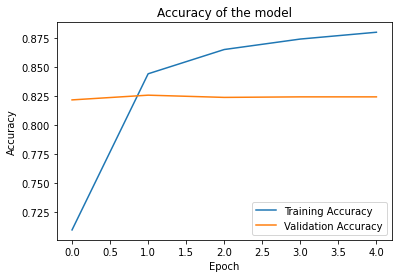

In [63]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

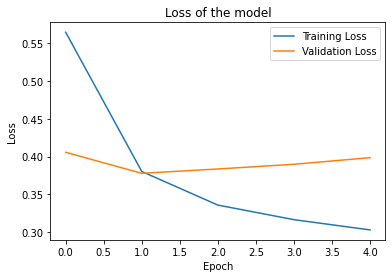

In [64]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Long Short-Term Memory (LSTM)

In [65]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [66]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [67]:
model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=32,
            mask_zero=True
        ),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [69]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 175ms/step - loss: 0.6934 - accuracy: 0.4734


[0.6933683753013611, 0.4734169542789459]

In [71]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 52s 443ms/step - loss: 0.5422 - accuracy: 0.7136 - val_loss: 0.3764 - val_accuracy: 0.8270
Epoch 2/5
102/102 [==============================] - 55s 534ms/step - loss: 0.3684 - accuracy: 0.8364 - val_loss: 0.3563 - val_accuracy: 0.8365
Epoch 3/5
102/102 [==============================] - 44s 429ms/step - loss: 0.3484 - accuracy: 0.8462 - val_loss: 0.3526 - val_accuracy: 0.8369
Epoch 4/5
102/102 [==============================] - 45s 436ms/step - loss: 0.3415 - accuracy: 0.8481 - val_loss: 0.3500 - val_accuracy: 0.8367
Epoch 5/5
102/102 [==============================] - 44s 430ms/step - loss: 0.3373 - accuracy: 0.8507 - val_loss: 0.3496 - val_accuracy: 0.8374


In [72]:
model.evaluate(test_data)

13/13 [==============================] - 2s 159ms/step - loss: 0.3505 - accuracy: 0.8367


[0.3505094051361084, 0.8366671800613403]